# Using HMC to sample the inducing points

- Pure MCMC on all the training points is a problem due to the high correlations between them.
- Variational Inference does a poor job at properly modelling uncertainty - often I find points that are overly confident.
   - Although I wonder if this was due to insufficient inducing points?
   - I also noticed this was more a problem when the two latent functions had different lengthscales? Maybe the underlying distribution became less Gaussian or more correlated?

Here we use HMC to sample the values of the inducing points.

In [330]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np

In [331]:
x = np.sort(np.random.randn(100)*5).astype(np.float32)[:,None]
f = (np.sin(x/5)+1).astype(np.float32)
y = (np.random.randn(100,1)*0.1+f).astype(np.float32)
z = np.linspace(-10,10,5,dtype=np.float32)[:,None]

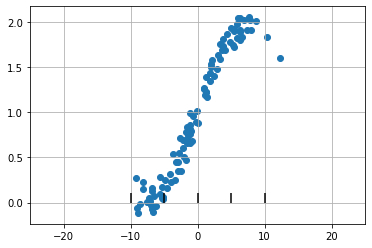

In [332]:
plt.scatter(x[:,0],y[:,0])
plt.vlines(z,0,0.1)
plt.xlim([-25,25])
plt.grid()

In [333]:
logp = 0
u = tf.Variable(np.array([[0,0.2,1,1.6,1.9]]),dtype=np.float32)
#u = tf.Variable(np.array([[1,1,1,1,1]]),dtype=np.float32)
mean = k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@tf.transpose(u)
cov = k.matrix(x,x)-k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@k.matrix(z,x)
likelihoodvariance=0.1
pfu = tfd.MultivariateNormalFullCovariance(tf.transpose(mean),cov+likelihoodvariance*tf.eye(100))
tf.reduce_sum(pfu.log_prob(tf.transpose(y)))

<tf.Tensor: shape=(), dtype=float32, numpy=10.102432>

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-5.56906], dtype=float32)>

In [335]:
k = psd_kernels.ExponentiatedQuadratic(length_scale=5.0)
gpz = tfd.GaussianProcess(k, z)
u = tf.Variable(np.random.randn(1,len(z)),dtype=tf.float32)

@tf.function
def model_log_prob(u): 
    """Returns log probability of data given model"""
    logp = 0
    mean = k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@tf.transpose(u)
    cov = k.matrix(x,x)-k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@k.matrix(z,x)
    likelihoodvariance=0.01
    pfu = tfd.MultivariateNormalFullCovariance(tf.transpose(mean),cov+likelihoodvariance*tf.eye(100))
    logp+=tf.reduce_sum(pfu.log_prob(tf.transpose(y)))
    logp+=gpz.log_prob(u) #prior
    #logp += tf.reduce_sum(tfd.Normal(u,1).log_prob(y))
    return logp

num_results = 600
num_burnin_steps = 1000
initial_chain_states = [u]
kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=model_log_prob,
            step_size=np.float64(0.001),
            num_leapfrog_steps=1)
kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8), target_accept_prob=np.float64(0.75))
from time import time

@tf.function
def run_mcmc():
    preds, kernel_results = tfp.mcmc.sample_chain(num_steps_between_results=10,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_states,
        kernel=kernel)
    return preds, kernel_results

start = time()
preds, kernel_results = run_mcmc()
print("Time: %0.2f" % (time()-start))
print(np.mean(kernel_results.inner_results.is_accepted))

/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Time: 5.52
0.625


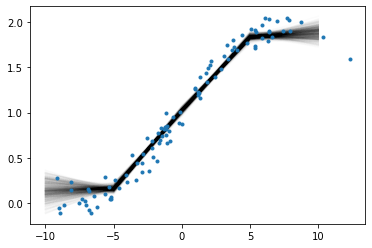

In [336]:
plt.plot(z,tf.transpose(preds[0][::1,0,:]),'-k',alpha=0.01);
#plt.plot(z,tf.transpose(u),'b-')
plt.plot(x,y,'.')

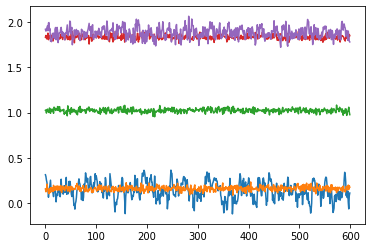

In [337]:
plt.plot(preds[0][:,0,:]);

In [338]:
mean = k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@tf.transpose(preds[0][:,0,:])
cov = k.matrix(x,x)-k.matrix(x,z)@tf.linalg.inv(k.matrix(z,z))@k.matrix(z,x)
likelihoodvariance=1e-4
pfu = tfd.MultivariateNormalFullCovariance(tf.transpose(mean),cov+likelihoodvariance*tf.eye(100))

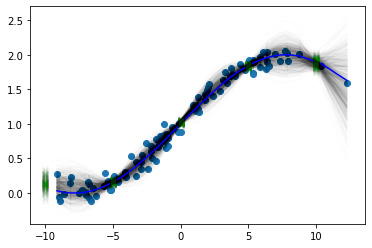

In [341]:
plt.plot(x,tf.transpose(pfu.sample(1)[0,:,:]),'-k',alpha=0.01);
#plt.xlim([-12,12])
#plt.ylim([-0.5,3])
plt.plot(x,f,'b-')
plt.scatter(x,y)
plt.plot(z,tf.transpose(preds[0][:,0,:]),'xg',alpha=0.01);